# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [68]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
df = pd.read_csv('real_estate_data.csv', sep='\t')

In [3]:
df.head(2)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.7,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0


In [4]:
df.shape

(23699, 22)

array([[<AxesSubplot: title={'center': 'total_images'}>,
        <AxesSubplot: title={'center': 'last_price'}>,
        <AxesSubplot: title={'center': 'total_area'}>,
        <AxesSubplot: title={'center': 'rooms'}>],
       [<AxesSubplot: title={'center': 'ceiling_height'}>,
        <AxesSubplot: title={'center': 'floors_total'}>,
        <AxesSubplot: title={'center': 'living_area'}>,
        <AxesSubplot: title={'center': 'floor'}>],
       [<AxesSubplot: title={'center': 'kitchen_area'}>,
        <AxesSubplot: title={'center': 'balcony'}>,
        <AxesSubplot: title={'center': 'airports_nearest'}>,
        <AxesSubplot: title={'center': 'cityCenters_nearest'}>],
       [<AxesSubplot: title={'center': 'parks_around3000'}>,
        <AxesSubplot: title={'center': 'parks_nearest'}>,
        <AxesSubplot: title={'center': 'ponds_around3000'}>,
        <AxesSubplot: title={'center': 'ponds_nearest'}>],
       [<AxesSubplot: title={'center': 'days_exposition'}>,
        <AxesSubplot: >, 

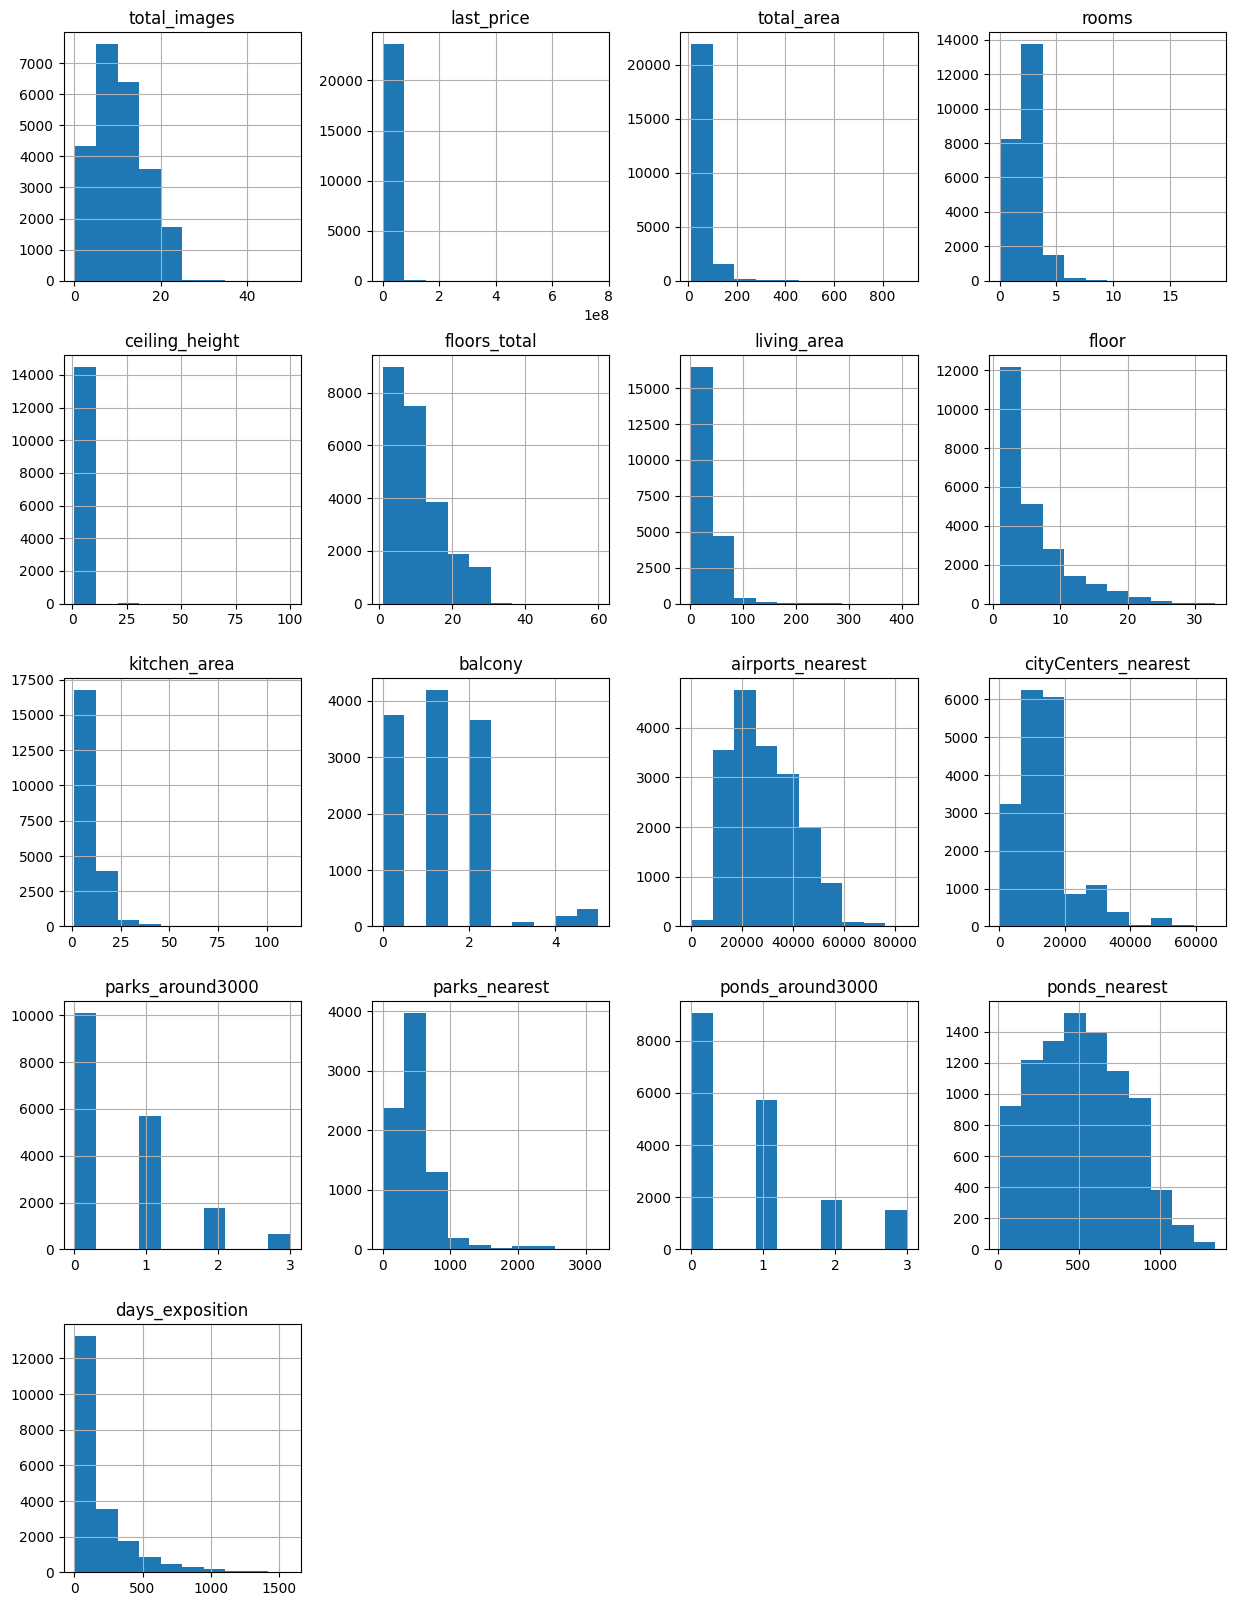

In [5]:
df.hist(figsize=(15, 20))

### Предобработка данных


#### Посмотрим какие поля сколько пропусков содержат:

<AxesSubplot: >

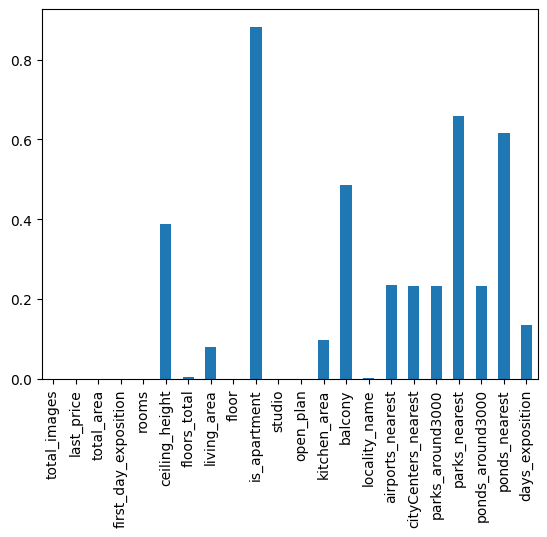

In [6]:
df.isna().mean().plot.bar()

Больше всего пропусков содержат следующие поля:<br>
<ul>
    <li></li>
    <li></li>
    <li></li>
</ul>
В случае с колличеством балконов, наличием в приделах 3000 м. парков и прудов, отсутствие данных можно приранятьотсутствию таких объектов, т.е. заменить пропущенные значения на ноль.


In [7]:
df['balcony'] = df['balcony'].fillna(0)
df['parks_around3000'] = df['parks_around3000'].fillna(0)
df['ponds_around3000'] = df['ponds_around3000'].fillna(0)

К пропускам данных могли привести следующие факторы:<bк>

#### Рассмотрим типы данных в столбцах

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Большенство числовых значений представленны в формате float64. Даже если признак может быть выражен целым числов из-за наличия пропусков столбец будет преобразован в формат вещесвтвенных чисел, т.к. значение NaN к этому формату данных.<br><br>
Поле 'first_day_exposition' – содержит даты, но в формате object. Переведем значаения этого столбца в формат datetime (Timestamp), для удобной манируляции данными при работе.

In [9]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dt%H:%M:%S')

In [10]:
type(df['first_day_exposition'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [11]:
df.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

#### Изучим уникальные значения в столбце с названиями и устраним неявные дубликаты:

In [12]:
len(df['locality_name'].unique())

365

In [51]:
# df['locality_name'].unique()

In [14]:
df['locality_name'] = df['locality_name'].str.replace('ё', 'е')
df['locality_name'] = df['locality_name'].str.replace('городской поселок', 'поселок')
df['locality_name'] = df['locality_name'].str.replace('поселок городского типа', 'поселок')
df['locality_name'] = df['locality_name'].str.replace('село', '')
df['locality_name'] = df['locality_name'].str.replace('деревня', '')


In [15]:
len(df['locality_name'].unique())

323

#### Найдём и устраним редкие и выбивающиеся значения

Поле `total_images` может влиять на привлекательность объявление, но врядли повлияет на стоимость объекта.
Поэтому, начнем с поля `'last_price'`:

<AxesSubplot: >

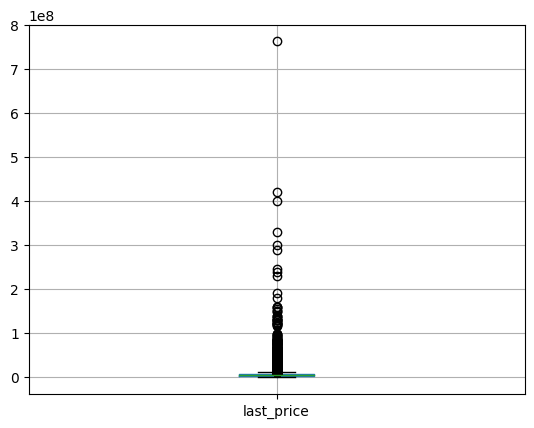

In [16]:
df.boxplot('last_price')

Какой-то объект явно вылетел в космос, посмотрим на него:

<AxesSubplot: >

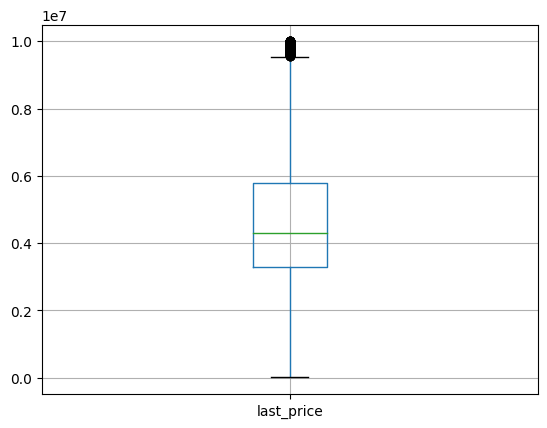

In [17]:
df.query('last_price < 10000000').boxplot('last_price')

In [18]:
df[df['last_price'] == df['last_price'].max()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
12971,19,763000000.0,400.0,2017-09-30,7,NaN,10.0,250.0,10,NaN,...,NaN,2.0,Санкт-Петербург,25108.0,3956.0,1.0,530.0,3.0,756.0,33.0


400 кв. метров, 4 км. от центра Питера, т.к. я не знаток luxury недвижимости, понятия не имею насколько это адекватно. Посмотрим какая доля объектов недвижимости с ценой выше 10 млн.

In [19]:
df[df['last_price'] > 100000000]['last_price'].count() / df['last_price'].count() *100

0.15612473100130808

0.15 % – Думаю такие объекты можно исключить из анализа, т.к. их число не велико, но они могут сильно исказить результаты:

In [20]:
df = df[df['last_price'] < 100000000]

Далее рассмотрим поле `'total_area'`:

<AxesSubplot: >

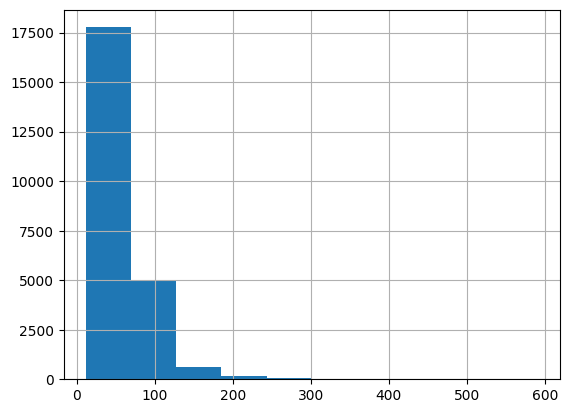

In [21]:
df['total_area'].hist()

<AxesSubplot: >

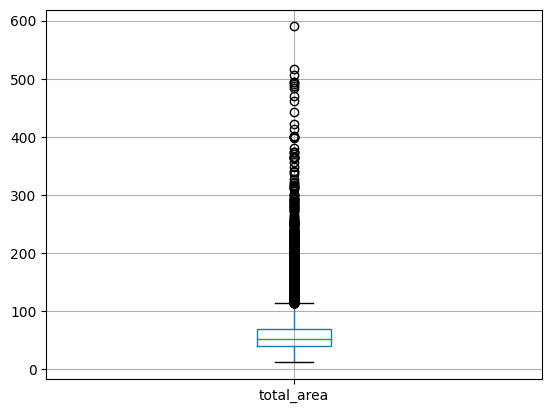

In [22]:
df.boxplot('total_area')

In [23]:
df['total_area'].max()

590.0

590 кв.метров – это конечно очень большая квартира, но в принципе, какой-нибудь пентхаус может занимать такую площадь. Не думаю, что здесь закралась ошибка

Далее рассмотрим  поле `'first_day_exposition'`:

In [24]:
print('MIN first_day_exposition:', df['first_day_exposition'].min())
print('MAX first_day_exposition:', df['first_day_exposition'].max())

MIN first_day_exposition: 2014-11-27 00:00:00
MAX first_day_exposition: 2019-05-03 00:00:00


<AxesSubplot: >

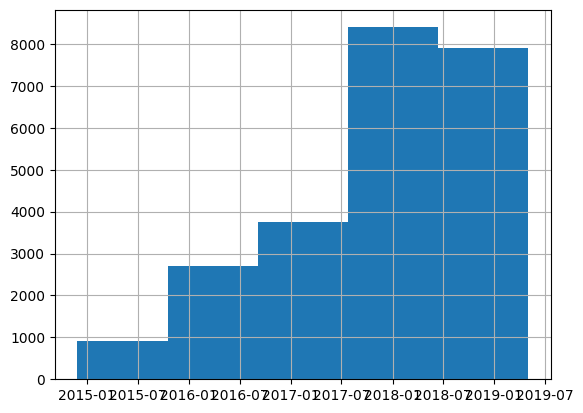

In [25]:
df['first_day_exposition'].hist(bins=5) # 5 – это 5 лет

Видимо, данные накапливались постепенно. Выглядит адекватно, публикаций времён династии Романовых нет, объявлений из будущего тоже.

Далее рассмотрим поле `'rooms'`:

<AxesSubplot: >

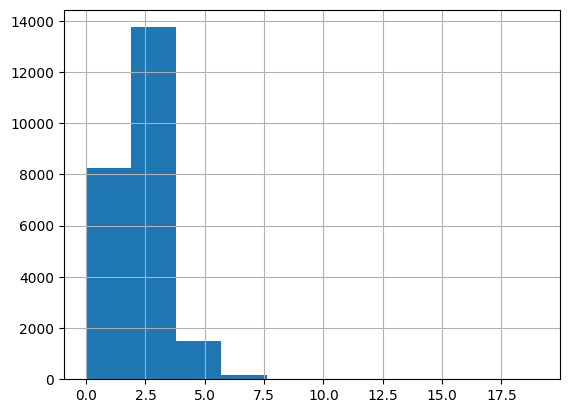

In [26]:
df['rooms'].hist()

In [27]:
df['rooms'].max()

19

19 комнат. Посмотрим на этот объек поближе:

In [28]:
df[df['rooms'] == df['rooms'].max()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
14498,6,32250000.0,374.6,2018-06-09,19,NaN,5.0,264.5,2,NaN,...,27.6,0.0,Санкт-Петербург,19497.0,3574.0,0.0,NaN,2.0,548.0,114.0


In [29]:
# рассчитаем среднюю площадь на одну комнату
df[df['rooms'] == df['rooms'].max()]['total_area'] / 19

14498    19.715789
Name: total_area, dtype: float64

19.7 кв.метров на комнату – это адекватно. Хотя объект, конечно, странный. Может в прошлом коммуналка. Пока оставим без изменений

Далее рассмотрим поле `'ceiling_height'`:

In [30]:
print('MIN ceiling_height:', df['ceiling_height'].min())
print('MAX ceiling_height:', df['ceiling_height'].max())

MIN ceiling_height: 1.0
MAX ceiling_height: 100.0


<AxesSubplot: >

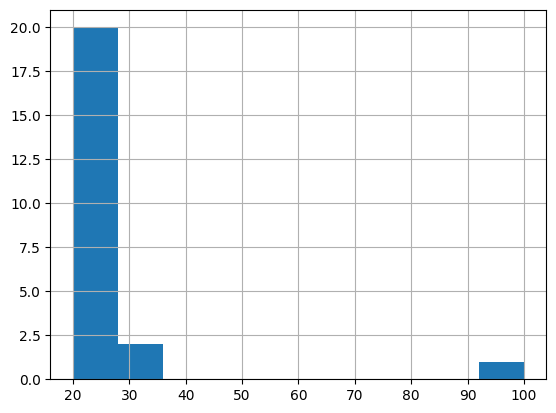

In [31]:
df['ceiling_height'].hist(range=(20, 100))

Значения больше 20 и до сорока, скорее всего, являются ошибкой, в которой при заполнении данных забыли поставить запятую, отделяющую целую и дробную часть исправить их можно, просто разделив на 10. Значение равное 100 – ошибка, но её причины неизвестны, по этому ....

In [32]:
df['ceiling_height'] = df['ceiling_height'].map(lambda x: x/10 if 20 <= x < 40 else x)

<AxesSubplot: >

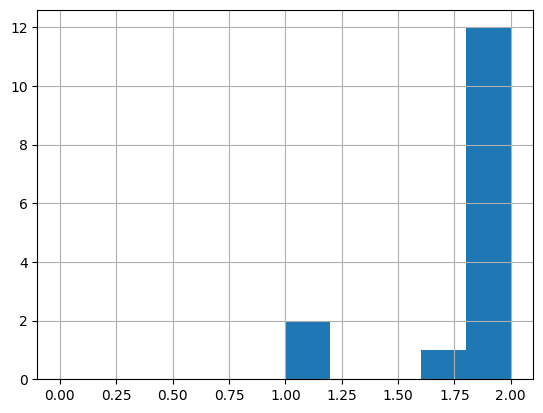

In [33]:
df['ceiling_height'].hist(range=(0, 2))

Далее рассмотрим поле `'floors_total'`:

In [34]:
print('MIN floors_total:', df['floors_total'].min())
print('MAX floors_total:', df['floors_total'].max())

MIN floors_total: 1.0
MAX floors_total: 60.0


<AxesSubplot: >

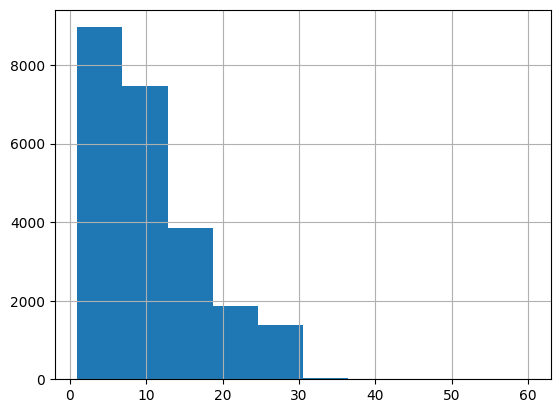

In [35]:
df['floors_total'].hist()

В целом, выглядит адекватно. 60й этаж – это конечно высоковато, но вполне может быть.

Далее рассмотрим поле `'living_area'`:

<AxesSubplot: >

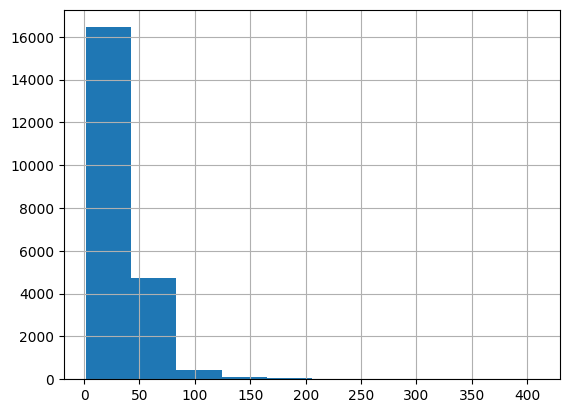

In [36]:
df['living_area'].hist()

На первый взгляд, всё выгялдит адекватно. <br>
Проверим есть ли объекты, у которых жилая площадь, превышает общую, чего быть не может

In [37]:
df[df['living_area'] > df['total_area']]['total_area'].count()

0

Таких объектов нет, что хорошо. Посмотрим на данные через boxplot

<AxesSubplot: >

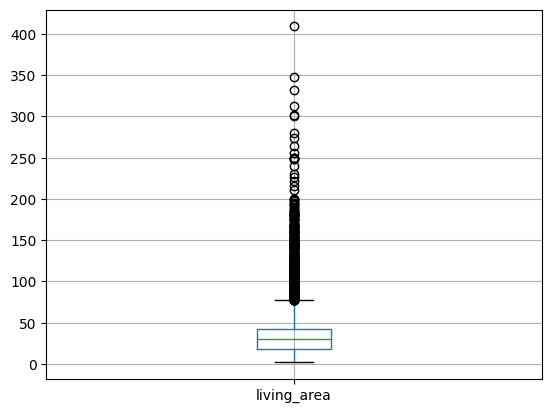

In [38]:
df.boxplot('living_area')

Имеются значение, превышающие Q3 + 1.5*IQR. Это могут быть как ошибки, так и реально большие объекты. Если это второй случай, то и цена у них будет должна быть пропорционально больше.<br>
Посмотрим на зависимость этих величин:

<AxesSubplot: xlabel='living_area', ylabel='last_price'>

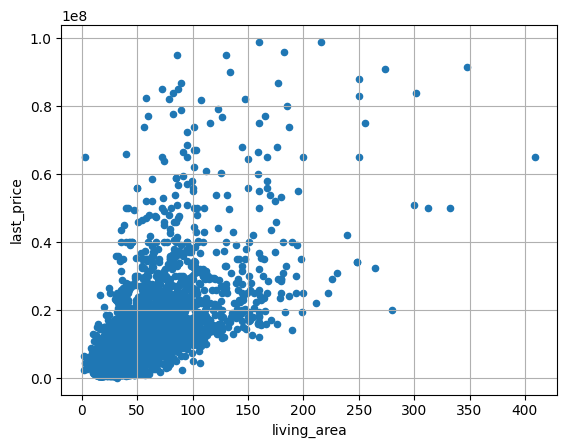

In [39]:
df.plot.scatter(x='living_area',
                  y='last_price',
                  grid=True
                  )

In [40]:
df.query("living_area > 250 and last_price < 30000000")

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
20273,12,20000000.0,460.8,2019-03-20,6,3.1,3.0,279.6,1,NaN,...,55.5,0.0,Санкт-Петербург,43756.0,15459.0,1.0,852.0,3.0,122.0,21.0


В целом, всё выглядит адекватно. Возможно в дальнейшем при расчёте средней арифмитической некоторые экстримальные значения надо будет исключить

Далее рассмотрим поле `'floor'` и `floors_total`:

In [41]:
print('Самый низкий этаж:', df['floor'].min()) # Не должно быть значений < 1 (хотя теоретически, могут быть цоколи)
print('Самыое маленькое здание:', df['floors_total'].min()) # Тут точно не должно быть значений < 1
print('Самое высокое здание:', df['floors_total'].max())
print('Самое выcоко расположенный объект:', df['floor'].max())

Самый низкий этаж: 1
Самыое маленькое здание: 1.0
Самое высокое здание: 60.0
Самое выcоко расположенный объект: 33


Отрицательных этажей нет и даже равных нулю – это хорошо. Шестидесяти этажное здание – высоковато, но адекватно.
Проверим, нет ли объектов, в которых квартира расположена выше крыши:

In [42]:
df[df['floor'] > df['floors_total']]['floor'].count()

0

Ошибок нет

Далее рассмотрим поле `'kitchen_area'`:

<AxesSubplot: >

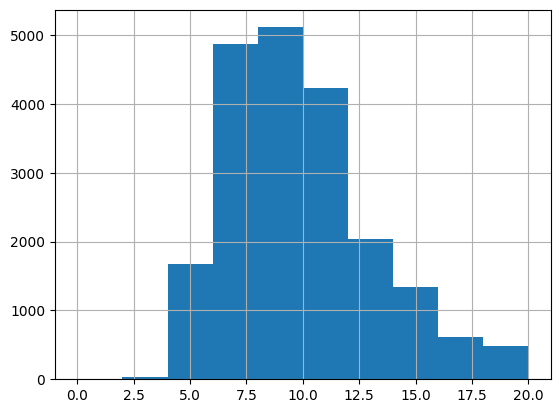

In [43]:
df['kitchen_area'].hist(range=(0, 20))

Кухня может быть даже очень большой, но она должна увеличиваться пропорционально общей площади квартиры.
Проверим это:

<AxesSubplot: xlabel='total_area', ylabel='kitchen_area'>

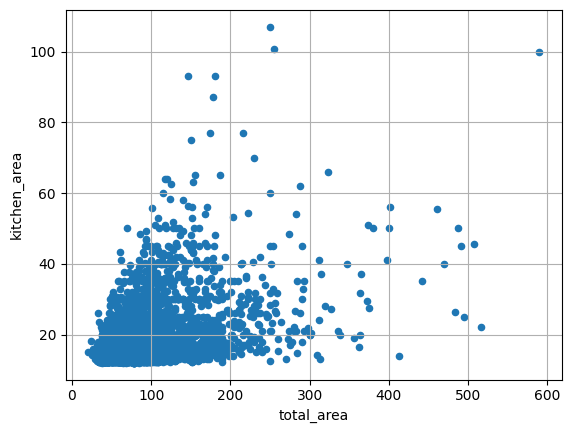

In [44]:
df[df['kitchen_area'] > 12].plot.scatter(x='total_area',
                y='kitchen_area',
                grid=True
                )

Из графика scatter plot вывод сделать сложно посмотрим на отношение площади кузни к площади всей квартиры

<AxesSubplot: >

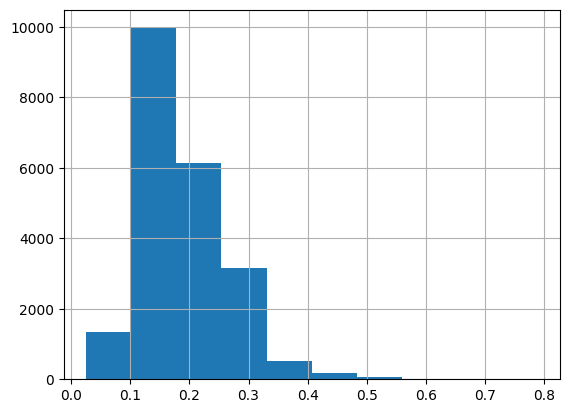

In [45]:
(df['kitchen_area'] / df['total_area']).hist()

In [46]:
df[(df['kitchen_area'] / df['total_area']) > 0.5]['kitchen_area'].count()

60

 Это странно, когда кухня занимает больше половины квартиры. Но в чем тут может быть ошибка, тоже не понятно. Ну по крайней мере, таких объектов не много.

Такие поля как:

### Посчитайте и добавьте в таблицу новые столбцы

Добавbv в таблицу новые столбцы со следующими параметрами:
1. Цена одного квадратного метра;

In [47]:
df['m2_price'] = df['last_price'] / df['total_area']

2. День недели публикации объявления;
3. Месяц публикации объявления;
4. Год публикации объявления;

In [48]:
df['weekday_of_publication'] =  df['first_day_exposition'].dt.weekday
df['month_of_publication']   =  df['first_day_exposition'].dt.month
df['year_of_publication']    =  df['first_day_exposition'].dt.year

5. тип этажа квартиры (значения — «первый», «последний», «другой»);

In [55]:
df['floor_type'] = 'другой'
df.loc[df['floor'] == 1, 'floor_type'] = 'первый'
df.loc[df['floor'] == df['floors_total'], 'floor_type'] = 'последний'

7. Расстояние до центра города в километрах;

In [79]:
df['cityCenters_nearest'] = df['cityCenters_nearest'].fillna(0)
df['cityCenters_nearest_km'] = (round(df['cityCenters_nearest'] / 1000)).astype(int)

In [80]:
df[['cityCenters_nearest_km', 'cityCenters_nearest']]

,cityCenters_nearest_km,cityCenters_nearest
0,16,16028.0
1,19,18603.0
2,14,13933.0
3,7,6800.0
4,8,8098.0
...,...,...
23694,4,4232.0
23695,0,0.0
23696,0,0.0
23697,10,10364.0


### Проведите исследовательский анализ данных

### Общий вывод

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [ ]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [ ]  определены пропущенные значения
- [ ]  заполнены пропущенные значения там, где это возможно
- [ ]  есть пояснение, какие пропущенные значения обнаружены
- [ ]  изменены типы данных
- [ ]  есть пояснение, в каких столбцах изменены типы и почему
- [ ]  устранены неявные дубликаты в названиях населённых пунктов
- [ ]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [ ]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [ ]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [ ]  посчитано и добавлено в таблицу: месяц публикации объявления
- [ ]  посчитано и добавлено в таблицу: год публикации объявления
- [ ]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [ ]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [ ]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [ ]  построены гистограммы для каждого параметра
- [ ]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [ ]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [ ]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [ ]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [ ]  в каждом этапе есть промежуточные выводы
- [ ]  есть общий вывод